# Exploring Sydney suburbs for opening a new restaurant

### BUSINESS PROBLEM

You are working in a boutique consulting firm specialised in Restaurant Marketing. An client is looking to open a new **Italian restaurant** in Sydney, however, he is not sure about the best location and marketing strategy for his new venue. So you are assigned to help him to develop a comprehensive marketing program. Sydney is a vibrant city that shines all year with spectacular events. It is best known for its tourist attractions and idyllic beaches. Strolling around the city suburbs, it hardly find a clean niche to open up a new restaurants among established competitors without a data-driven methodology. How would you advise your client in deciding his restaurant location using data science?

### DATA
Synthesised from *Start Your Own Restaurant and More: Pizzeria, Cofeehouse, Deli, Bakery, Catering Business* published by [Entrepreneur Press](https://www.entrepreneur.com/article/73384 "How to Start a Restaurant"), the following components are deemed as key factors in selecting restaurant location: demographics, traffic density, crime rates, competitor, and property affordability. We may not be able to solve all these factors in such a short period of time, however, some of these considerations could actually be addressed by using available public datasets or web-scraping. 

1. [**NSW_suburb.geojson**](https://data.gov.au/dataset/ds-dga-91e70237-d9d1-4719-a82f-e71b811154c6/details)
This dataset contains all **suburb names** and their **boundry coordinates** in New South Wales, Australia. It will be used for defining suburb boundries and calculating **suburb centres coordinates**. The latter will be used as anchor location for searching venues in *Foursuqare* API.
2. [**sydney_suburb_postcode_all.csv**]()
I generated this dataset by web-scraping, please see *Methodology* for details.
This dataset contains all **suburb names** and **postcodes** within Sydney metro area. It will be used to subset Sydney suburb coordinates from NSW_suburb.geojson.
3. [**sydney_property_price.csv**]()
I generated this dataset by web-scraping, please see *Methodology* for details
This dataset contains median values of sell and rent prices for houses and units in each Sydney suburb. This dataset will be used for plotting property affordability of each suburb.
4. [**sydney_demography_by_suburb.csv**]()
I generated this dataset by web-scraping, please see *Methodology* for details
This dataset comprises **Suburb**, **Population** and **Age**. This dataset will be used for plotting demographics of each suburb.
5. [**Sydney_venues.csv**]()
List of venues of each suburb. Generated from *Foursquare* API.

By using above datasets, we will find suburbs with the least competitors by K-mean clustering with *Foursquare* venues data. Then we will pick up suburbs that have affordable property price, high population density. Last we will look into selected suburb to identify potential locations for opening up a Italian restaurant based on *Foursquare* venues data.


### METHODOLOGY 

In [3]:
# Import required modules
import os
from bs4 import BeautifulSoup
from requests import get
import pandas as pd
import numpy as np
import time
import random
import itertools
import json # library to handle JSON files
import folium # library for plot map
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

#### Obtain geojson data

Download the **NSW_suburb.geojson** data and open it.

In [4]:
with open('NSW_suburb.geojson') as json_data:
    NSW_data = json.load(json_data)
NSW_data_feature = NSW_data['features']
len(NSW_data_feature)

4592

#### Obtain Sydney suburb list

I first scraped the list of Sydney suburbs from wiki using `requests` and `Beautifulsoup4`.

In [ ]:
# There are four pages for the list, so we stored the web links for these four pages into `domain`
headers = ({'User-Agent':'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})
domain = []
domain.append("https://en.wikipedia.org/wiki/Category:Suburbs_of_Sydney")
domain.append("https://en.wikipedia.org/w/index.php?title=Category:Suburbs_of_Sydney&pagefrom=Dharruk%2C+New+South+Wales#mw-pages")
domain.append("https://en.wikipedia.org/w/index.php?title=Category:Suburbs_of_Sydney&pagefrom=Macgraths+Hill%0AMcGraths+Hill%2C+New+South+Wales#mw-pages")
domain.append("https://en.wikipedia.org/w/index.php?title=Category:Suburbs_of_Sydney&pagefrom=Singletons+Mill%2C+New+South+Wales#mw-pages")

# Create a empty list to store content
suburb_list =[]
for i in range(len(domain)):
    response = get(domain[i], headers=headers)
    # Check if get infomation from the target website, "200" denotes ok.
    print(response)
    html_soup = BeautifulSoup(response.text, 'html.parser')
    # After inspecting the first "find_all", the list we need is in [1]. The result will be a list of lists
    suburb_list.append(html_soup.find_all('div', class_="mw-category")[1].find_all('div', class_="mw-category-group"))

In [ ]:
# After exploring the list, we found the layer for suburb names
# instantiate the dataframe
Sydney_suburb = pd.DataFrame(columns=["Suburb"])

# iterating the list to extract suburb names
for i in range(len(suburb_list)):
    tmp_list_1 = suburb_list[i]
    for j in range(len(tmp_list_1)):
        tmp_list_2 = tmp_list_1[j].find_all('a')
        for k in range(len(tmp_list_2)):
            suburb_name = tmp_list_2[k].contents[0]
            Sydney_suburb = Sydney_suburb.append({'Suburb': suburb_name}, ignore_index=True)

In [ ]:
# Remove the first row as it is not a suburb
Sydney_suburb = Sydney_suburb[Sydney_suburb['Suburb'] != 'List of Sydney suburbs']

# Split the text based on comma into two columns
Sydney_suburb = pd.DataFrame(Sydney_suburb.Suburb.str.split(',',1).tolist(),
                             columns = ['Suburb','State'])
Sydney_suburb.head()

In [ ]:
# Save as csv and open it in excel, change "sydney central business district" as "Sydney"
#Sydney_suburb.to_csv("sydney_suburb_wiki.csv", index = False)

#### Obtain Sydney suburb postcode table

Secondly, I scraped the postcode table of all Sydney suburbs from [here](https://www.costlessquotes.com.au/postcode_tool/postcode_list_NSW.php).


In [ ]:
headers = ({'User-Agent':'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})
domain = "https://www.costlessquotes.com.au/postcode_tool/postcode_list_NSW.php"
response = get(domain, headers=headers)
# Check if get infomation from the target website, "200" denotes ok.
print(response)

In [ ]:
html_soup = BeautifulSoup(response.text, 'html.parser')
postcode_containers = html_soup.find_all('table', class_="table")[0].find_all('tr')

# instantiate the dataframe
Sydney_area_postcode = pd.DataFrame(columns=["Postcode", "Areas"])

for i in range(1, len(postcode_containers)):
    area_list = postcode_containers[i].find_all('td')[2].find('a').contents[0]
    postcode = postcode_containers[i].find_all('td')[0].contents[0]
    Sydney_area_postcode = Sydney_area_postcode.append({'Postcode': postcode,
                                                        'Areas': area_list},
                                                       ignore_index=True)
Sydney_area_postcode.head() 

In [ ]:
# Write as a csv file for latter use
#Sydney_area_postcode.to_csv('Sydney_area_postcode.csv', index = False)

#### Link Sydney suburb with its postcode

In [ ]:
Sydney_area_postcode = pd.read_csv('Sydney_area_postcode.csv')
Sydney_suburb = pd.read_csv('sydney_suburb_wiki.csv')

In [ ]:
# instantiate the dataframe
Sydney_suburb_postcode = pd.DataFrame(columns=["Suburb", "Postcode"])

for suburb in Sydney_suburb['Suburb']:
    for index in range(len(Sydney_area_postcode['Areas'])):
        # This is to seperate items with the same postcode using comma and remove space
        area_list = [x.strip(' ') for x in Sydney_area_postcode['Areas'][index].split(',')]
        if suburb in area_list:
            postcode = Sydney_area_postcode.loc[index, 'Postcode']
            Sydney_suburb_postcode = Sydney_suburb_postcode.append({"Suburb":suburb, "Postcode":postcode}, ignore_index=True)

Sydney_suburb_postcode

We then need to combine `Sydney_suburb` and `Sydney_suburb_postcode` as `Sydney_suburb_postcode_all`. Since the suburb name format in the geojson file is different from `Sydney_suburb_postcode_all`, we created a column **Suburbs_with_boundries** in `Sydney_suburb_postcode_all` for later use.

In [ ]:
# Merge suburb and postcode
Sydney_suburb_postcode_all = pd.merge(Sydney_suburb, 
                               Sydney_suburb_postcode, 
                               left_on='Suburb', 
                               right_on='Suburb',
                               how='left')

In [ ]:
# Extract suburb names from geojson file
suburb_list_geojson = []
for i in NSW_data_feature:
    suburb_list_geojson.append(i['properties']['nsw_loca_2'])

# Covert the list to dataframe
suburb_list_geojson_df = pd.DataFrame(suburb_list_geojson, columns=['Suburbs_with_boundries'])

# Add one more column as key column for merging
suburb_list_geojson_df['Suburb_key'] = suburb_list_geojson_df['Suburbs_with_boundries'].str.title()
suburb_list_geojson_df.head()

In [ ]:
Sydney_suburb_postcode_all = pd.merge(Sydney_suburb_postcode_all, 
                               suburb_list_geojson_df, 
                               left_on='Suburb', 
                               right_on='Suburb_key',
                               how='left')

# Remove redundant column
Sydney_suburb_postcode_all = Sydney_suburb_postcode_all.drop(['Suburb_key'], axis=1) 

Sydney_suburb_postcode_all.head()

Since there might be wrong and missing postcodes, I did manual check for the csv file and did changes accordingly. 

In [ ]:
# Save to csv file and check duplicate and wrong postcode manually according to Domain website
#Sydney_suburb_postcode_all.to_csv("sydney_suburb_postcode_all.csv", index = False)

#### Scraping demography data based on the Sydney suburb list

Once we obtained and curated the Sydney suburb and postcode list, we used it for scraping demography data. 

##### Test if we can scrap info from a given web

=================================================

If the return code is 200, then it indicates we successfully scraped.

In [ ]:
headers = ({'User-Agent':'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})
domain = "https://www.domain.com.au/suburb-profile/currawong-beach-nsw-2108"
response = get(domain, headers=headers)

print(response)

Exploring the html file to find the target data

In [ ]:
html_soup = BeautifulSoup(response.text, 'html.parser')
house_containers = html_soup.find_all('div', class_="suburb-profile__row")
demography = house_containers[0].find_all('div', class_="css-jkrtif")[0].find_all('div', class_="css-54bw0x")
demography

===============================================================================

##### Start to scrap info for all suburbs

Once we are familiar with the html structure, we can do scraping for all suburbs.

In [ ]:
# Define a function for compiling info into array
def getDemography(suburb_names, postcode_list, state='NSW'):
    
    Demography_list=[]
    
    for suburb, postcode in zip(suburb_names, postcode_list):
        
        print(suburb)
        
        suburb = suburb.replace(' ', '-')
            
        # create the API request URL
        headers = ({'User-Agent':
                    'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})
        url = 'https://www.domain.com.au/suburb-profile/{}-nsw-{}'.format(
            suburb, 
            postcode)
            
        # make the GET request
        response = get(url, headers=headers)
        
        # Parse the html
        html_soup = BeautifulSoup(response.text, 'html.parser')
        
        info_containers = html_soup.find_all('div', class_="suburb-profile__row")
        
        try:
            if info_containers != []:

                demography = info_containers[0].find_all('div', class_="css-jkrtif")[0].find_all('div', class_="css-54bw0x")

                if demography != []:

                    population = demography[0].text
                    population = population.replace(',', '')
                    age = demography[1].text

                else:     
                    # sometime there will be a promotion section on the result site, hence demography info locates in different section.
                    demography = info_containers[1].find_all('div', class_="css-jkrtif")[0].find_all('div', class_="css-54bw0x")
                    
                    if demography != []:
                        population = demography[0].text
                        population = population.replace(',', '')
                        age = demography[1].text
                    
                    else:
                        # sometimes there will be no infomation.
                        population = "NA"
                        age = "NA"

            else:
                # sometimes there is no infomation
                population = "NA"
                age = "NA" 
        
        except:
            pass

        # return only relevant information for suburb
        Demography_list.append([(
            suburb, 
            postcode, 
            population, 
            age)])
        
        # Wait a given time bewteen 5 to 15 seconds for scraping the next website to mimic a humanbeing search.
        time.sleep(random.randint(5,15))     
    
    return(Demography_list)

Split the whole list into several parts, so we can check abnormality as the html structure may be different for a specific query.

In [ ]:
sydney_suburb = pd.read_csv('sydney_suburb_postcode_all.csv')
sydney_suburb.head()

In [ ]:
sydney_demography = getDemography(suburb_names=sydney_suburb['Suburb'].str.lower(), postcode_list=sydney_suburb['Postcode'])

In [ ]:
sydney_demography2 = getDemography(suburb_names=sydney_suburb['Suburb'][65:100].str.lower(), postcode_list=sydney_suburb['Postcode'][65:100])

In [ ]:
sydney_demography3 = getDemography(suburb_names=sydney_suburb['Suburb'][100:137].str.lower(), postcode_list=sydney_suburb['Postcode'][100:137])

In [ ]:
sydney_demography4 = getDemography(suburb_names=sydney_suburb['Suburb'][137:183].str.lower(), postcode_list=sydney_suburb['Postcode'][137:183])

In [ ]:
sydney_demography5 = getDemography(suburb_names=sydney_suburb['Suburb'][183:351].str.lower(), postcode_list=sydney_suburb['Postcode'][183:351])

In [ ]:
sydney_demography6 = getDemography(suburb_names=sydney_suburb['Suburb'][351:695].str.lower(), postcode_list=sydney_suburb['Postcode'][351:695])

In [ ]:
# Once finish, concatenate all lists as one
sydney_demography_all = sydney_demography + sydney_demography2 + sydney_demography3 + sydney_demography4 + sydney_demography5 + sydney_demography6

# Convert the list into a dataframe
sydney_demography_list = pd.DataFrame([item for sydney_demography_all in sydney_demography_all for item in sydney_demography_all])
sydney_demography_list.columns = ['Suburb',
                                 'Postcode',
                                 'Population',
                                 'Age']
sydney_demography_list.head()

In [ ]:
# Add "Suburbs_with_boundries" as keys for searching boundries later against geojson file. Doing so can make sure no suburb will be missed due to unmatched format
# for example there is a dash in "MOUNT KURING-GAI" in the geojson file
sydney_demography_list['Suburbs_with_boundries'] = sydney_suburb['Suburbs_with_boundries']
sydney_demography_list.head()

In [ ]:
# Save as csv file and check maunally in excel. 
#sydney_demography_list.to_csv('sydney_demography_by_suburb.csv', index=False)

In [10]:
sydney_demography_data = pd.read_csv('sydney_demography_by_suburb.csv')
sydney_demography_data.shape

(698, 5)

#### Subset the NSW geojson file to only contain Sydney suburbs

In [11]:
NSW_data_feature_new = []
Suburb_list = []

for i in range(len(NSW_data_feature)):
    # check if the suburb in Sydney
    if NSW_data['features'][i]['properties']['nsw_loca_2'] in sydney_demography_data['Suburbs_with_boundries'].tolist():
        
        # This part is to deal with suburb with the same name and not in Sydney area
        postcode = NSW_data['features'][i]['properties']['nsw_loca_4']
        suburb = NSW_data['features'][i]['properties']['nsw_loca_2']
        
        if postcode is not None:
            postcode_sydney = sydney_demography_data.loc[sydney_demography_data['Suburbs_with_boundries'] == suburb, 'Postcode'].tolist()[0]
                     
            # "postcode_sydney" is int, you need to convert to str to be able to compare with j, which is a str
            if postcode == str(postcode_sydney):
                NSW_data_feature_new.append(NSW_data_feature[i])
                Suburb_list.append(NSW_data['features'][i]['properties']['nsw_loca_2'].title())
        else:
            NSW_data_feature_new.append(NSW_data_feature[i])
            Suburb_list.append(NSW_data['features'][i]['properties']['nsw_loca_2'].title())

In [12]:
# Check the length of final list, we found that the total number is still not 698 as in the sydney_demography_data. There must be some repeat in NSW_data_feature_new
len(NSW_data_feature_new)

700

In [13]:
# Find repeated items in a list
def Repeat(x): 
    _size = len(x) 
    repeated = [] 
    for i in range(_size): 
        k = i + 1
        for j in range(k, _size): 
            if x[i] == x[j] and x[i] not in repeated: 
                repeated.append(x[i]) 
    return repeated

In [14]:
# Check the repeat suburb names, there are two of them ['Chatswood West', 'Lovett Bay']
print(Repeat(Suburb_list))

['Chatswood West', 'Lovett Bay']


In [15]:
# Let's check if they have postcode
postcode_test = []
for i in range(len(NSW_data_feature)):
    if NSW_data['features'][i]['properties']['nsw_loca_2'] == 'Chatswood West'.upper():
        postcode_test.append(NSW_data['features'][i]['properties']['nsw_loca_4'])

# No wonder they were selected into the final list, because they do not have postcodes for us to select and end up put into the final list.
postcode_test

[None, None]

In [16]:
# Let's check if this is just duplicates in NSW_suburb.geojson file
loc_pid_test = []
for i in range(len(NSW_data_feature)):
    if NSW_data['features'][i]['properties']['nsw_loca_2'] == 'Lovett Bay'.upper():
        loc_pid_test.append(NSW_data['features'][i]['properties']['loc_pid'])
        
# Looks like they are the same suburb ['NSW5092', 'NSW5092']
loc_pid_test

['NSW5092', 'NSW5092']

In [17]:
# Let's just keep one of them in the final list
NSW_data_feature_final = []
tmp_list = []

for i in range(len(NSW_data_feature_new)):
    # check if the suburb name is one of ['Chatswood West', 'Lovett Bay']
    if NSW_data_feature_new[i]['properties']['nsw_loca_2'].title() in Repeat(Suburb_list):
        
        tmp_list.append(NSW_data_feature_new[i])
        
    else:
        NSW_data_feature_final.append(NSW_data_feature_new[i])

NSW_data_feature_final.append(tmp_list[1])
NSW_data_feature_final.append(tmp_list[3])

len(NSW_data_feature_final)

698

In [19]:
# Assign the final list to the 'features' layer of NSW geojson list. So the geojson file only contains suburbs in Sydney
NSW_data['features'] = NSW_data_feature_final

# Save this new geojson file
#from json import dump
#with open('Sydney_suburb.geojson', 'w') as f:
#   dump(NSW_data, f)

#### Scraping property median price data based on the Sydney suburb list

In [18]:
sydney_suburb = pd.read_csv('sydney_demography_by_suburb.csv')
sydney_suburb.head()

,Suburb,Postcode,Population,Age,Suburbs_with_boundries
0,abbotsbury,2176,4242,40 to 59,ABBOTSBURY
1,abbotsford,2046,5366,40 to 59,ABBOTSFORD
2,acacia-gardens,2763,3786,20 to 39,ACACIA GARDENS
3,agnes-banks,2753,919,40 to 59,AGNES BANKS
4,airds,2560,2939,5 to 19,AIRDS


In [ ]:
# Define a function for compiling info into array
def getMedianPrice(suburb_names, postcode_list, state='NSW'):
    
    # For display progress bar
    bar = progressbar.ProgressBar(maxval=sydney_suburb.shape[0],
                                  widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    
    price_list=[]
    
    bar.start()
    
    for suburb, postcode in zip(suburb_names, postcode_list):
        
        bar.update(sydney_suburb['Suburb'].tolist().index(suburb)+1)
                    
        # create the API request URL
        headers = ({'User-Agent':
                    'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})
        url = 'https://www.realestate.com.au/neighbourhoods/{}-{}-nsw'.format(
            suburb, 
            postcode)
            
        # make the GET request
        response = get(url, headers=headers)
        
        html_soup = BeautifulSoup(response.text, 'html.parser')
        house_containers = html_soup.find_all('div', class_="section", id ="median-price")
        
        try:
            
            if house_containers != []:    

                median_price = house_containers[0].find_all('div', class_="price h1 strong")

                median_price_house_buy = median_price[0].text
                median_price_house_buy = median_price_house_buy.replace('$', '')
                median_price_house_buy = median_price_house_buy.replace(',', '')

                median_price_house_rent = median_price[1].text
                median_price_house_rent = median_price_house_rent.replace('$', '')
                median_price_house_rent = median_price_house_rent.replace(',', '')
                median_price_house_rent = median_price_house_rent.replace(' PW', '')

                median_price_unit_buy = median_price[2].text
                median_price_unit_buy = median_price_unit_buy.replace('$', '')
                median_price_unit_buy = median_price_unit_buy.replace(',', '')

                median_price_unit_rent = median_price[3].text
                median_price_unit_rent = median_price_unit_rent.replace('$', '')
                median_price_unit_rent = median_price_unit_rent.replace(',', '')
                median_price_unit_rent = median_price_unit_rent.replace(' PW', '')

            else:
                median_price_house_buy = "no data"
                median_price_house_rent = "no data"
                median_price_unit_buy = "no data"
                median_price_unit_rent = "no data"
       
        except:
            pass
    
        # return only relevant information for suburb
        price_list.append([(
            suburb, 
            postcode, 
            median_price_house_buy, 
            median_price_house_rent, 
            median_price_unit_buy, 
            median_price_unit_rent)])
        
        # Wait a given time bewteen 1 to 15 seconds for scraping the next website to mimic a humanbeing search.
        time.sleep(random.randint(5,10))     
    
    return(price_list)

    bar.finish()

In [ ]:
sydney_property = getMedianPrice(suburb_names=sydney_suburb['Suburb'], postcode_list=sydney_suburb['Postcode'])

In [ ]:
sydney_property_price = pd.DataFrame([item for sydney_property in sydney_property for item in sydney_property])
sydney_property_price.columns = ['Suburb',
                                 'Postcode',
                                 'House_buy',
                                 'House_rent',
                                 'Unit_buy',
                                 'Unit_rent']
sydney_property_price.head()

In [ ]:
# Merge demograph and property tables as one dataset

sydney_demograph_property_by_suburb = pd.merge(sydney_suburb,
                                               sydney_property_price,
                                               left_on = "Suburb",
                                               right_on = "Suburb",
                                               how = "left"
                                              )
sydney_demograph_property_by_suburb.drop(['Postcode_y'], inplace=True, axis=1)
sydney_demograph_property_by_suburb.rename(columns={'Postcode_x':'Postcode', 'Suburbs_with_boundries':'Suburb_name_geojson'}, inplace=True)
sydney_demograph_property_by_suburb.head()

In [ ]:
# Repalce str 'no data' as np.NaN, so that we can then assign data type as float
sydney_demograph_property_by_suburb['House_buy'] = sydney_demograph_property_by_suburb['House_buy'].replace(['no data'], np.NaN)
sydney_demograph_property_by_suburb['House_rent'] = sydney_demograph_property_by_suburb['House_rent'].replace(['no data'], np.NaN)
sydney_demograph_property_by_suburb['Unit_buy'] = sydney_demograph_property_by_suburb['Unit_buy'].replace(['no data'], np.NaN)
sydney_demograph_property_by_suburb['Unit_rent'] = sydney_demograph_property_by_suburb['Unit_rent'].replace(['no data'], np.NaN)

In [ ]:
# Correct data type in each column
sydney_demograph_property_by_suburb['House_buy'] = sydney_demograph_property_by_suburb['House_buy'].astype(float)
sydney_demograph_property_by_suburb['House_rent'] = sydney_demograph_property_by_suburb['House_rent'].astype(float)
sydney_demograph_property_by_suburb['Unit_buy'] = sydney_demograph_property_by_suburb['Unit_buy'].astype(float)
sydney_demograph_property_by_suburb['Unit_rent'] = sydney_demograph_property_by_suburb['Unit_rent'].astype(float)
sydney_demograph_property_by_suburb['Postcode'] = sydney_demograph_property_by_suburb['Postcode'].astype(str)

##### Modeling
Using sklearn package to model data.

As **House_rent** and **House_buy** have linear relationship, we can use this to predict missing values for both **House_buy** and **House_rent**.

In [ ]:
plt.figure(figsize=(8,8))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
for key, value in {'Unit_rent':'House_rent', 'House_buy':'Unit_buy', 'Unit_buy':'Unit_rent', 'House_rent':'House_buy'}.items():
    
    # Store the image index in i 
    i = list({'Unit_rent':'House_rent', 'House_buy':'Unit_buy', 'Unit_buy':'Unit_rent', 'House_rent':'House_buy'}.keys()).index(key) +1
    
    # plot figures in 2 by 2 matrix and start from 1 to 4
    plt.subplot(2, 2, i)
    sns.regplot(y=value, x=key,
            data=sydney_demograph_property_by_suburb[sydney_demograph_property_by_suburb[[value, key]].notnull().all(1)],
               color="blue")

Select rows that need to be predicted, which only have one value for either **House_rent** or **House_buy**.

In [ ]:
# Store rows that have both 'house_rent' and 'house_buy' as NaN
data_all_NaN = sydney_demograph_property_by_suburb[sydney_demograph_property_by_suburb[['House_rent', 'House_buy']].isnull().all(1)]

# Select rows with at least one NaN for column 'House_rent' and 'House_buy'
data_for_pred = sydney_demograph_property_by_suburb[sydney_demograph_property_by_suburb[['House_rent', 'House_buy']].isnull().any(1)]

# Select rows with at least one non-NaN for column 'House_rent' and 'House_buy'
data_for_pred = One_price_data[One_price_data[['House_rent', 'House_buy']].notnull().any(1)]

# Fill NaN as 0 so can be used in the following for loop
data_for_pred = data_for_pred[['Suburb', 'Postcode', 'House_rent', 'House_buy']].fillna(0)

data_for_pred

Select rows that will be used for modeling, which have values for **House_rent** and **House_buy**.

In [ ]:
data_for_model = sydney_demograph_property_by_suburb[sydney_demograph_property_by_suburb[['House_rent', 'House_buy']].notnull().all(1)]

##### Creating train and test dataset

Train/Test Split involves splitting the dataset into training and testing sets respectively, which are mutually exclusive. After which, you train with the training set and test with the testing set. 
This will provide a more accurate evaluation on out-of-sample accuracy because the testing dataset is not part of the dataset that have been used to train the data. It is more realistic for real world problems.

This means that we know the outcome of each data point in this dataset, making it great to test with! And since this data has not been used to train the model, the model has no knowledge of the outcome of these data points. So, in essence, it is truly an out-of-sample testing.

Lets split our dataset into train and test sets, 80% of the entire data for training, and the 20% for testing. We create a mask to select random rows using __np.random.rand()__ function: 

In [ ]:
msk = np.random.rand(len(data_for_model)) < 0.8
train = data_for_model[msk]
test = data_for_model[~msk]

##### Simple Regression Model
Linear Regression fits a linear model with coefficients $\theta = (\theta_1, ..., \theta_n)$ to minimize the 'residual sum of squares' between the independent x in the dataset, and the dependent y by the linear approximation. 

In [ ]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
train_x = np.asanyarray(train[['House_buy']])
train_y = np.asanyarray(train[['House_rent']])
regr.fit (train_x, train_y)
# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

In [ ]:
plt.scatter(train.House_buy, train.House_rent,  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("House buy median price")
plt.ylabel("House rent median price")
plt.show()

##### Evaluation
we compare the actual values and predicted values to calculate the accuracy of a regression model. Evaluation metrics provide a key role in the development of a model, as it provides insight to areas that require improvement.

In [ ]:
from sklearn.metrics import r2_score

test_x = np.asanyarray(test[['House_buy']])
test_y = np.asanyarray(test[['House_rent']])
test_y_hat = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_hat - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_hat - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y_hat , test_y) )

##### Prediction

We now can use the model to predict missing values.

In [ ]:
new_data = []

for x, y, i, k in zip(data_for_pred.House_buy, data_for_pred.House_rent, data_for_pred.Suburb, data_for_pred.Postcode):
    if y != 0:
        x_pred = (y - regr.intercept_[0])/regr.coef_[0][0]
        new_data.append([(i, k, y, x_pred)])
    else:
        y_pred = regr.coef_[0][0]*x + regr.intercept_[0]
        new_data.append([(i, k, y_pred, x)])

In [ ]:
# Convert the list into a dataframe
data_after_pred = pd.DataFrame([item for new_data in new_data for item in new_data])
data_after_pred.columns = ['Suburb',
                           'Postcode',
                           'House_rent',
                           'House_buy']
data_after_pred

In [ ]:
# Concatenate all three dataframes together.
data_all = pd.concat([data_for_model[['Suburb', 'Postcode', 'House_rent', 'House_buy']], data_after_pred, data_all_NaN[['Suburb', 'Postcode', 'House_rent', 'House_buy']]], 
                     ignore_index=True)
data_all.shape

In [ ]:
data_final = pd.merge(sydney_demograph_property_by_suburb, 
                      data_all, 
                      left_on='Suburb',
                     right_on='Suburb',
                     how='left')

# remove redundant columns and rename columns
data_final_tmp = data_final.drop(['Postcode_y', 'House_buy_x', 'House_rent_x'], axis=1)
data_final_tmp = data_final_tmp.rename(columns = {'Postcode_x': 'Postcode', 'House_rent_y': 'House_rent', 'House_buy_y':'House_buy'}, inplace=False)

# Scale buy value by 10000
data_final_tmp['Unit_buy'] = data_final_tmp['Unit_buy']/1000000
data_final_tmp['House_buy'] = data_final_tmp['House_buy']/1000000

# Rename the buy column to indicate the scale is million
data_final_tmp = data_final_tmp.rename(columns = {'Unit_buy': 'Unit_buy/M', 'House_buy':'House_buy/M'}, inplace=False)

In [ ]:
# Save this dataframe as the final table for suburb, postcode, demography and property price
#data_final_tmp.to_csv('sydney_postcode_demo_property_final.csv', index = False)

#### Choropleth map 
Now, let's create our own `Choropleth` map of population, age and property median price for Sydney.

##### Population map

In [ ]:
# Sydney latitude and longitude values
latitude = -33.892319
longitude = 151.146167

# create a plain Sydney map
population_map = folium.Map(location=[latitude, longitude], zoom_start=11, tiles='cartodbpositron')

# create a list for population scale
bins = list(range(0, 60000, 10000))

# generate choropleth map using the total population of each suburb in Sydney
population_map.choropleth(
    geo_data=NSW_data,
    data=sydney_demography_data,
    columns=['Suburbs_with_boundries', 'Population'],
    key_on='feature.properties.nsw_loca_2',
    fill_color='BuGn', 
    fill_opacity=0.7, 
    line_opacity=0.9,
    legend_name='Population by Suburb',
    bins=bins,
    reset=True
)

# The map sometimes is too big to open in Jupyter, so export the map and open it in another Tab.
population_map.save(os.path.join('/Users/jun/Dropbox/Course/coursera/IBM_Data_Science/Course9_Applied Data Science Capstone/github_project', 'GeoJSON_and_choropleth_demography.html'))

##### Age map

We need to do some modifications for **Age** as it is category string and also contains missing value. We need to replace missing value as 60+ and create a new column with number to indicate the age range.

In [158]:
# If suburb has no value for age, I then assume that this suburb age range should be 60+
sydney_demography_data[['Age']] = sydney_demography_data[['Age']].fillna('60+')

# Now we have 4 categories for the age range
sydney_demography_data.Age.unique()

array(['40 to 59', '20 to 39', '5 to 19', '60+'], dtype=object)

In [159]:
# Create a new column to indicate the age range
sydney_demography_data['Age_map'] = sydney_demography_data['Age'].map({'5 to 19': 6, '20 to 39': 21, '40 to 59': 41, '60+':61}) 

In [ ]:
# Sydney latitude and longitude values
latitude = -33.892319
longitude = 151.146167

# create a plain Sydney map
population_map = folium.Map(location=[latitude, longitude], zoom_start=11, tiles='cartodbpositron')

# Create a bin to plot age range
bins = [5, 20, 40, 60, 100]

# generate choropleth map using the total population of each suburb in Sydney
population_map.choropleth(
    geo_data=NSW_data,
    data=sydney_demography_data,
    columns=['Suburbs_with_boundries', 'Age_map'],
    key_on='feature.properties.nsw_loca_2',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.9,
    legend_name='Age by Suburb',
    bins=bins,
    reset=True
)

# The map sometimes is too big to open in Jupyter, so export the map and open it in another Tab.
population_map.save(os.path.join('/Users/jun/Dropbox/Course/coursera/IBM_Data_Science/Course9_Applied Data Science Capstone/github_project', 'GeoJSON_and_choropleth_age.html'))

##### Median price map

In [ ]:
# Sydney latitude and longitude values
latitude = -33.892319
longitude = 151.146167

# create a plain Sydney map
population_map = folium.Map(location=[latitude, longitude], zoom_start=11, tiles='cartodbpositron')

# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(data_final_tmp['House_buy/M'].min(),
                              data_final_tmp['House_buy/M'].max(),
                              10, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration


# generate choropleth map using the total population of each suburb in Sydney
population_map.choropleth(
    geo_data=Sydney_data,
    data=data_final_tmp,
    columns=['Suburb_name_geojson', 'House_buy/M'],
    key_on='feature.properties.nsw_loca_2',
    fillColor='#gray',
    threshold_scale=threshold_scale,
    fill_color='BuPu', 
    fill_opacity=0.7, 
    line_opacity=0.9,
    legend_name='House median price by Suburb (million)',
    reset=True
)

# The map sometimes is too big to open in Jupyter, so export the map and open it in another Tab.
population_map.save(os.path.join('/Users/jun/Dropbox/Course/coursera/IBM_Data_Science/Course9_Applied Data Science Capstone/github_project', 'GeoJSON_and_choropleth_median_price.html'))

#### Exploring Sydney suburbs with Foursuqre API

In [34]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# import k-means from clustering stage
from sklearn.cluster import KMeans

import requests # library to handle requests

In [22]:
with open('Sydney_suburb.geojson') as json_data:
    Sydney_data = json.load(json_data)

# Store features layer
suburb_data = Sydney_data['features']

To simplify the question, We assume the centre coordinates of the polygon as the suburb centre. We then define a function for centre coordinates calculation using boundry coordinates.

In [23]:
# calculates the centroid of a list of (x, y) tuples
def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

# define the dataframe columns
column_names = ['Suburb', 'Latitude','Longitude'] 

# instantiate the dataframe
Sydney_suburbs = pd.DataFrame(columns=column_names)

for data in suburb_data:  
    suburb_name = data['properties']['nsw_loca_2']    
    suburb_latlon = centeroidnp(np.asarray(data['geometry']['coordinates'][0][0]))    
    suburb_lat = suburb_latlon[1]
    suburb_lon = suburb_latlon[0]  
    Sydney_suburbs = Sydney_suburbs.append({'Suburb': suburb_name,
                                            'Latitude': suburb_lat,
                                            'Longitude': suburb_lon}, ignore_index=True)
    
Sydney_suburbs.head()

,Suburb,Latitude,Longitude
0,CONCORD,-33.853568,151.108335
1,WOLLSTONECRAFT,-33.832982,151.192215
2,PUTNEY,-33.829572,151.107471
3,TEN MILE HOLLOW,-33.323251,151.086745
4,KILLARA,-33.770675,151.152533


In [24]:
print('Sydney metro area has {} suburbs'.format(Sydney_suburbs.shape[0]))

Sydney metro area has 698 suburbs


Next, we are going to start utilizing the Foursquare API to explore the suburbs and segment them.

#### Define Foursquare Credentials and Version

In [26]:
CLIENT_ID = 'UFUOK1DDHYEBMIKZCVZE1VWLZ5S4MNUMRBYKO0UTWZ5MV42Y' # your Foursquare ID
CLIENT_SECRET = 'PNLQYCQGW2QIHAYNRU42Q4HCDMK4SOYG3YVTKEQIR1TD3XVS' # your Foursquare Secret
VERSION = '20191005' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UFUOK1DDHYEBMIKZCVZE1VWLZ5S4MNUMRBYKO0UTWZ5MV42Y
CLIENT_SECRET:PNLQYCQGW2QIHAYNRU42Q4HCDMK4SOYG3YVTKEQIR1TD3XVS


Let's create a function to repeat the same process to all the suburbs in Sydney.

In [35]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburb', 
                  'Suburb Latitude', 
                  'Suburb Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    # Wait a given time bewteen 3 to 8 seconds for scraping the next website to mimic a humanbeing search.
        #time.sleep(random.randint(3,8))
    
    return(nearby_venues)

In [39]:
sydney_venues = getNearbyVenues(names=Sydney_suburbs['Suburb'],
                                   latitudes=Sydney_suburbs['Latitude'],
                                   longitudes=Sydney_suburbs['Longitude']
                                  )

CONCORD
WOLLSTONECRAFT
PUTNEY
TEN MILE HOLLOW
KILLARA
HAMMONDVILLE
WATTLE GROVE
SEAFORTH
DOVER HEIGHTS
WATERFALL
RAMSGATE
BELFIELD
CROYDON PARK
MERRYLANDS WEST
DUNDAS VALLEY
ENGADINE
KIRRIBILLI
WOOLWICH
BUSBY
WOODPARK
WERRINGTON DOWNS
SCOTLAND ISLAND
SMEATON GRANGE
TERREY HILLS
EAST KURRAJONG
RABY
EAST KILLARA
OXLEY PARK
LILLI PILLI
WARRAWEE
DAVIDSON
KINGSFORD
CENTRAL COLO
THE DEVILS WILDERNESS
HOBARTVILLE
KURRAJONG
LA PEROUSE
NAREMBURN
DARLING POINT
CENTENNIAL PARK
HOMEBUSH
CONCORD WEST
CHIFLEY
EAST RYDE
QUEENS PARK
ERSKINE PARK
BROOKVALE
NARRAWEENA
BELROSE
ELLIS LANE
CENTRAL MACDONALD
COLLAROY
WORONORA DAM
WRIGHTS CREEK
MOGO CREEK
ZETLAND
SYLVANIA WATERS
CHISWICK
BICKLEY VALE
MINTO HEIGHTS
ELIZABETH HILLS
HOLROYD
CLOVELLY
MARRICKVILLE
DHARRUK
BLIGH PARK
BASS HILL
GEORGES HALL
COTTAGE POINT
WERRINGTON
DUNDAS
CANLEY VALE
CONDELL PARK
CLAREMONT MEADOWS
MCGRATHS HILL
NORTH WILLOUGHBY
CHIPPING NORTON
MILPERRA
CAMPSIE
ROOKWOOD
BONNYRIGG
BEVERLY HILLS
RYDALMERE
ROSSMORE
BOX HILL
YAGOONA
BAN

In [80]:
# Let's check the size of the resulting dataframe
print(sydney_venues.shape[0])

5585


In [106]:
# Let's check how many venues were returned for each suburbs and list the top 20
sydney_venues_num = sydney_venues.groupby('Suburb').count()
sydney_venues_num = sydney_venues_num.drop(columns=['Suburb Latitude', 'Suburb Longitude', 'Venue Latitude', 'Venue Longitude', 'Venue Category'])
sydney_venues_num = sydney_venues_num.sort_values(['Venue'], ascending=False).reset_index(drop=False)
sydney_venues_num['Suburb'] = sydney_venues_num['Suburb'].str.title()
print(sydney_venues_num.shape[0])
sydney_venues_num.head(20)

565


,Suburb,Venue
0,Darlinghurst,100
1,The Rocks,100
2,Surry Hills,89
3,Crows Nest,86
4,Newtown,85
5,Haymarket,83
6,Chippendale,79
7,Millers Point,73
8,Burwood,72
9,Sydney,72


As we can see here, only 565 suburbs returned venues. This may because the arbitary choice of suburb centre is not the real suburb centre, we should find a better way to define suburb centre in the future. 

We can aslo see the top 20 suburbs with the most venues number from the `sydney_venues_num` table. Note that we only limited 100 when retrieving data from Foursquare, but this does not impact the rank.

Let's then find out how many unique categories can be curated from all the returned venues.

In [102]:
print('There are {} uniques categories.'.format(len(sydney_venues['Venue Category'].unique())))

There are 341 uniques categories.


Using one hot encoding to create a matrix table for each suburb.

In [225]:
# one hot encoding
sydney_onehot = pd.get_dummies(sydney_venues[['Venue Category']], prefix="", prefix_sep="")

# add suburb column back to dataframe
sydney_onehot['Suburb'] = sydney_venues['Suburb'] 

# move suburb column to the first column
fixed_columns = [sydney_onehot.columns[-1]] + list(sydney_onehot.columns[:-1])
sydney_onehot = sydney_onehot[fixed_columns]

sydney_onehot.head()

,Suburb,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,CONCORD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CONCORD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CONCORD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CONCORD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CONCORD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [104]:
sydney_grouped = sydney_onehot.groupby('Suburb').mean().reset_index()
sydney_grouped

,Suburb,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,ABBOTSBURY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,ABBOTSFORD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0
2,AGNES BANKS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,AIRDS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,ALEXANDRIA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,YARRAMUNDI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
561,YARRAWARRAH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
562,YENNORA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
563,YOWIE BAY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


Let's find each suburb along with the top 10 most common venues and save into a dataframe.

In [108]:
#First, let's write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [141]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Suburb']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
suburbs_venues_sorted = pd.DataFrame(columns=columns)
suburbs_venues_sorted['Suburb'] = sydney_grouped['Suburb']

for ind in np.arange(sydney_grouped.shape[0]):
    suburbs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sydney_grouped.iloc[ind, :], num_top_venues)

suburbs_venues_sorted.head()

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ABBOTSBURY,Coffee Shop,Convenience Store,Flea Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
1,ABBOTSFORD,Café,Park,Wine Shop,Thai Restaurant,Pizza Place,Zoo,Filipino Restaurant,Falafel Restaurant,Farm,Farmers Market
2,AGNES BANKS,Movie Theater,Zoo,Flower Shop,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market
3,AIRDS,Fried Chicken Joint,Soccer Field,Fish Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
4,ALEXANDRIA,Café,Furniture / Home Store,Basketball Court,Italian Restaurant,Costume Shop,Bar,Pet Store,Flea Market,Australian Restaurant,Fish & Chips Shop


#### Run *k*-means to cluster the suburbs into clusters

In [139]:
# set number of clusters
kclusters = 4

sydney_grouped_clustering = sydney_grouped.drop('Suburb', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sydney_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 1, 1, 2, 1, 0, 1, 1, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [142]:
# add clustering labels
suburbs_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sydney_merged = Sydney_suburbs

# merge sydney_grouped with sydney_data to add latitude/longitude for each neighborhood
sydney_merged = sydney_merged.join(suburbs_venues_sorted.set_index('Suburb'), on='Suburb')

sydney_merged.head() # check the last columns!

,Suburb,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,CONCORD,-33.853568,151.108335,2.0,Café,Soccer Field,Italian Restaurant,Sports Bar,Dry Cleaner,Ice Cream Shop,Golf Course,Fish & Chips Shop,Farm,Farmers Market
1,WOLLSTONECRAFT,-33.832982,151.192215,1.0,Park,Train Station,Pet Store,Platform,Filipino Restaurant,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market
2,PUTNEY,-33.829572,151.107471,1.0,Indian Restaurant,Playground,Burger Joint,Zoo,Fish Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
3,TEN MILE HOLLOW,-33.323251,151.086745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,KILLARA,-33.770675,151.152533,1.0,Golf Course,Tourist Information Center,French Restaurant,Fountain,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field


In [143]:
# replace NaN in cluster labels as -1
sydney_merged['Cluster Labels'] = sydney_merged['Cluster Labels'].fillna(-1)
sydney_merged.head()

,Suburb,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,CONCORD,-33.853568,151.108335,2.0,Café,Soccer Field,Italian Restaurant,Sports Bar,Dry Cleaner,Ice Cream Shop,Golf Course,Fish & Chips Shop,Farm,Farmers Market
1,WOLLSTONECRAFT,-33.832982,151.192215,1.0,Park,Train Station,Pet Store,Platform,Filipino Restaurant,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market
2,PUTNEY,-33.829572,151.107471,1.0,Indian Restaurant,Playground,Burger Joint,Zoo,Fish Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
3,TEN MILE HOLLOW,-33.323251,151.086745,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,KILLARA,-33.770675,151.152533,1.0,Golf Course,Tourist Information Center,French Restaurant,Fountain,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field


In [144]:
# change dtype as int for column 'Cluster Labels'
sydney_merged['Cluster Labels'] = sydney_merged['Cluster Labels'].astype(int)
sydney_merged.dtypes

Suburb                     object
Latitude                  float64
Longitude                 float64
Cluster Labels              int64
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

Finally, let's visualize the resulting clusters along with population, age and property price.

Cluster with population

In [156]:
# Sydney latitude and longitude values
latitude = -33.892319
longitude = 151.146167

# create a plain Sydney map
population_map = folium.Map(location=[latitude, longitude], zoom_start=11, tiles='cartodbpositron')

# create a list for population scale
bins = list(range(0, 60000, 10000))

# generate choropleth map using the total population of each suburb in Sydney
population_map.choropleth(
    geo_data=NSW_data,
    data=sydney_demography_data,
    columns=['Suburbs_with_boundries', 'Population'],
    key_on='feature.properties.nsw_loca_2',
    fill_color='BuGn', 
    fill_opacity=0.7, 
    line_opacity=0.9,
    legend_name='Population by Suburb',
    bins=bins,
    reset=True
)

import matplotlib.cm as cm
import matplotlib.colors as colors

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sydney_merged['Latitude'], sydney_merged['Longitude'], sydney_merged['Suburb'], sydney_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(population_map)
    
import os
# The map sometimes is too big to open in Jupyter, so export the map and open it in another Tab.
population_map.save(os.path.join('/Users/jun/Dropbox/Course/coursera/IBM_Data_Science/Course9_Applied Data Science Capstone/github_project', 'GeoJSON_and_choropleth_cluster_population.html'))

/anaconda3/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Cluster with Age range

In [160]:
# Sydney latitude and longitude values
latitude = -33.892319
longitude = 151.146167

# create a plain Sydney map
population_map = folium.Map(location=[latitude, longitude], zoom_start=11, tiles='cartodbpositron')

# Create a bin to plot age range
bins = [5, 20, 40, 60, 100]

# generate choropleth map using the total population of each suburb in Sydney
population_map.choropleth(
    geo_data=NSW_data,
    data=sydney_demography_data,
    columns=['Suburbs_with_boundries', 'Age_map'],
    key_on='feature.properties.nsw_loca_2',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.9,
    legend_name='Age by Suburb',
    bins=bins,
    reset=True
)

import matplotlib.cm as cm
import matplotlib.colors as colors

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sydney_merged['Latitude'], sydney_merged['Longitude'], sydney_merged['Suburb'], sydney_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(population_map)

import os
# The map sometimes is too big to open in Jupyter, so export the map and open it in another Tab.
population_map.save(os.path.join('/Users/jun/Dropbox/Course/coursera/IBM_Data_Science/Course9_Applied Data Science Capstone/github_project', 'GeoJSON_and_choropleth_cluster_age.html'))

/anaconda3/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Cluster with property price

In [163]:
# Sydney latitude and longitude values
latitude = -33.892319
longitude = 151.146167

# create a plain Sydney map
population_map = folium.Map(location=[latitude, longitude], zoom_start=11, tiles='cartodbpositron')

# import data for median price
data_final_tmp = pd.read_csv('sydney_postcode_demo_property_final.csv')

# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(data_final_tmp['House_buy/M'].min(),
                              data_final_tmp['House_buy/M'].max(),
                              10, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

# generate choropleth map using the total population of each suburb in Sydney
population_map.choropleth(
    geo_data=Sydney_data,
    data=data_final_tmp,
    columns=['Suburb_name_geojson', 'House_buy/M'],
    key_on='feature.properties.nsw_loca_2',
    fillColor='#gray',
    threshold_scale=threshold_scale,
    fill_color='BuPu', 
    fill_opacity=0.7, 
    line_opacity=0.9,
    legend_name='House median price by Suburb (million)',
    reset=True
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sydney_merged['Latitude'], sydney_merged['Longitude'], sydney_merged['Suburb'], sydney_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(population_map)

import os
# The map sometimes is too big to open in Jupyter, so export the map and open it in another Tab.
population_map.save(os.path.join('/Users/jun/Dropbox/Course/coursera/IBM_Data_Science/Course9_Applied Data Science Capstone/github_project', 'GeoJSON_and_choropleth_cluster_median_price.html'))

/anaconda3/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster. 

In [147]:
sydney_merged.loc[sydney_merged['Cluster Labels'] == 0, sydney_merged.columns[[0] + list(range(4, sydney_merged.shape[1]))]]

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,SEAFORTH,Fish Market,Hotel,Bus Station,Event Service,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
18,BUSBY,Bus Station,Zoo,Fish Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
41,CONCORD WEST,Café,Bus Station,Zoo,Fish Market,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
165,MOUNT PRITCHARD,Bus Station,Zoo,Fish Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
249,ALLAMBIE HEIGHTS,Bus Station,Zoo,Fish Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
302,HENLEY,Bus Station,Skate Park,Australian Restaurant,Event Space,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
341,MARSFIELD,Garden,Bus Station,Zoo,Flea Market,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
383,MACQUARIE PARK,Bus Station,Park,Zoo,Fish Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
469,PORT BOTANY,Bus Station,Zoo,Fish Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop


In [148]:
sydney_merged.loc[sydney_merged['Cluster Labels'] == 1, sydney_merged.columns[[0] + list(range(4, sydney_merged.shape[1]))]]

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,WOLLSTONECRAFT,Park,Train Station,Pet Store,Platform,Filipino Restaurant,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market
2,PUTNEY,Indian Restaurant,Playground,Burger Joint,Zoo,Fish Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
4,KILLARA,Golf Course,Tourist Information Center,French Restaurant,Fountain,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
6,WATTLE GROVE,Coffee Shop,Pizza Place,Park,Bar,Bakery,Shopping Mall,Fast Food Restaurant,Supermarket,Paper / Office Supplies Store,Flower Shop
9,WATERFALL,Trail,Fast Food Restaurant,Platform,Zoo,Fish & Chips Shop,Event Space,Falafel Restaurant,Farm,Farmers Market,Field
...,...,...,...,...,...,...,...,...,...,...,...
688,HOXTON PARK,Furniture / Home Store,Zoo,Flea Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
689,AGNES BANKS,Movie Theater,Zoo,Flower Shop,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market
690,BONNET BAY,Deli / Bodega,Zoo,Flea Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
691,WORONORA,Bar,Lawyer,Zoo,Flea Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant


In [149]:
sydney_merged.loc[sydney_merged['Cluster Labels'] == 2, sydney_merged.columns[[0] + list(range(4, sydney_merged.shape[1]))]]

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,CONCORD,Café,Soccer Field,Italian Restaurant,Sports Bar,Dry Cleaner,Ice Cream Shop,Golf Course,Fish & Chips Shop,Farm,Farmers Market
10,RAMSGATE,Café,Italian Restaurant,Pub,Beach,Recreation Center,Thai Restaurant,Pizza Place,Filipino Restaurant,Falafel Restaurant,Farm
14,DUNDAS VALLEY,Italian Restaurant,Pub,Bathing Area,Café,Zoo,Fish & Chips Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
15,ENGADINE,Café,Playground,Zoo,Fish Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
16,KIRRIBILLI,Café,Thai Restaurant,Park,Italian Restaurant,Scenic Lookout,Pier,Tapas Restaurant,Lounge,Theater,Food & Drink Shop
...,...,...,...,...,...,...,...,...,...,...,...
686,SURRY HILLS,Café,Coffee Shop,Pub,Japanese Restaurant,Pizza Place,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Breakfast Spot,Yoga Studio
692,ROZELLE,Pub,Vegetarian / Vegan Restaurant,Bar,Café,Bus Station,Gym,Electronics Store,Pizza Place,Italian Restaurant,Bakery
693,THE PONDS,Coffee Shop,Grocery Store,Café,Shopping Mall,Thai Restaurant,Athletics & Sports,Filipino Restaurant,Farm,Farmers Market,Fast Food Restaurant
694,CARINGBAH SOUTH,Seafood Restaurant,Bakery,Café,Fish & Chips Shop,Event Service,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field


In [150]:
sydney_merged.loc[sydney_merged['Cluster Labels'] == 3, sydney_merged.columns[[0] + list(range(4, sydney_merged.shape[1]))]]

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,HAMMONDVILLE,Park,Baseball Field,Fish Market,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
8,DOVER HEIGHTS,Playground,Park,Zoo,Fish & Chips Shop,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
20,WERRINGTON DOWNS,Park,Fish Market,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
26,EAST KILLARA,Yoga Studio,Park,French Restaurant,Fish & Chips Shop,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
29,WARRAWEE,Park,Beach,Tennis Court,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
38,DARLING POINT,Park,Pharmacy,Harbor / Marina,Food Truck,Field,Event Service,Event Space,Falafel Restaurant,Farm,Fountain
98,ST IVES CHASE,Park,Airport,Fish Market,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
122,LANSDOWNE,Park,Fish Market,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
132,WHALAN,Soccer Field,Park,Zoo,Fish & Chips Shop,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
134,FAIRFIELD WEST,Park,Gym,Gas Station,Zoo,Fish & Chips Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field


In [151]:
sydney_merged.loc[sydney_merged['Cluster Labels'] == -1, sydney_merged.columns[[0] + list(range(4, sydney_merged.shape[1]))]]

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,TEN MILE HOLLOW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,EAST KURRAJONG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,OXLEY PARK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,CENTRAL COLO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,THE DEVILS WILDERNESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
667,GALSTON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,KELLYVILLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
673,NELSON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
682,KANGAROO POINT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We found that cluster 2 is differentiated from other clusters with restaurants. We then can narrow down the candidatial suburb list from cluster 2.

let's first insert the cluster labeling into dataframe with demography and median price data.

In [195]:
sydney_demography_data_cluster = pd.merge(data_final_tmp,
                                         sydney_merged[['Suburb', 'Cluster Labels']],
                                         left_on = 'Suburb_name_geojson',
                                         right_on = 'Suburb',
                                         how = 'left')
# remove redundant column and rename column
sydney_demography_data_cluster = sydney_demography_data_cluster.drop(columns=['Suburb_y'])
sydney_demography_data_cluster = sydney_demography_data_cluster.rename(columns={'Suburb_x':'Suburb'})
# set 'Age' as category type and reorder the category
sydney_demography_data_cluster['Age'] = sydney_demography_data_cluster['Age'].astype('category')
sydney_demography_data_cluster['Age'].cat.reorder_categories(['5 to 19', '20 to 39', '40 to 59', '60+'], inplace=True)

sydney_demography_data_cluster.head()

,Suburb,Postcode,Population,Age,Suburb_name_geojson,Unit_buy/M,Unit_rent,House_rent,House_buy/M,Cluster Labels
0,abbotsbury,2176,4242,40 to 59,ABBOTSBURY,NaN,NaN,600.0,0.8415,1
1,abbotsford,2046,5366,40 to 59,ABBOTSFORD,1.0275,595.0,875.0,2.1000,2
2,acacia-gardens,2763,3786,20 to 39,ACACIA GARDENS,NaN,NaN,540.0,0.7950,-1
3,agnes-banks,2753,919,40 to 59,AGNES BANKS,NaN,NaN,NaN,NaN,1
4,airds,2560,2939,5 to 19,AIRDS,NaN,NaN,450.0,0.4300,1


let's further narrow down the list by make a 2D scatter plot (Population vs. Houser_buy).

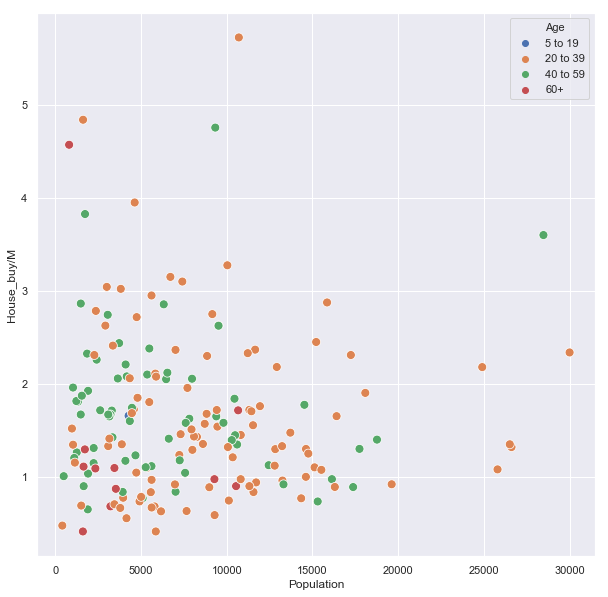

In [217]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="Population", y="House_buy/M", hue='Age', s=80,
                     data=sydney_demography_data_cluster[sydney_demography_data_cluster['Cluster Labels'] == 2])
plt.savefig("population_price_age_cluster2.png")

By looking the scatterplot, we can identify there are 5 suburbs fall into the category that with relatively low property price, high population density and middle age. Let's list them out.

In [227]:
suburb_candidate = sydney_demography_data_cluster[((sydney_demography_data_cluster['Cluster Labels'] == 2) & (sydney_demography_data_cluster['Population'] > 23000) & (sydney_demography_data_cluster['House_buy/M']<2.5))]
suburb_candidate

,Suburb,Postcode,Population,Age,Suburb_name_geojson,Unit_buy/M,Unit_rent,House_rent,House_buy/M,Cluster Labels
137,chatswood,2067,24900,20 to 39,CHATSWOOD,0.9780,615.0,900.0,2.1800,2
402,marrickville,2204,26607,20 to 39,MARRICKVILLE,0.6775,490.0,750.0,1.3200,2
499,parramatta,2150,25793,20 to 39,PARRAMATTA,0.5970,460.0,495.0,1.0800,2
534,randwick,2031,29994,20 to 39,RANDWICK,0.8850,595.0,1050.0,2.3375,2
565,ryde,2112,26507,20 to 39,RYDE,0.6325,500.0,650.0,1.3500,2


In [288]:
# Have a look of the composition of restaurant in these 5 suburbs.
sydney_grouped_sum = sydney_onehot.groupby('Suburb').sum().reset_index()
suburb_candidate_restaurant = sydney_grouped_sum.loc[sydney_grouped_sum['Suburb'].isin(list(suburb_candidate['Suburb'].str.upper()))]


# Only select Restaurant columns
suburb_candidate_restaurant = suburb_candidate_restaurant.loc[:, suburb_candidate_restaurant.columns.str.contains('Restaurant')]

suburb_candidate_restaurant['Suburb'] = sydney_grouped_sum['Suburb']

# move suburb column to the first column
fixed_columns = [suburb_candidate_restaurant.columns[-1]] + list(suburb_candidate_restaurant.columns[:-1])
suburb_candidate_restaurant = suburb_candidate_restaurant[fixed_columns]

suburb_candidate_restaurant

,Suburb,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Belgian Restaurant,...,Sri Lankan Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
111,CHATSWOOD,0,0,0,1,0,0,0,0,0,...,0,2,1,0,0,2,0,1,0,0
321,MARRICKVILLE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,8
402,PARRAMATTA,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
433,RANDWICK,0,0,0,0,0,0,0,0,0,...,0,1,0,0,2,7,0,0,0,1
462,RYDE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Then Let's find the top 10 most common restaurant types in respective suburb.

In [284]:
for index in list(suburb_candidate_restaurant.index):
    print("----"+suburb_candidate_restaurant.loc[index, :][0]+"----")
    print(suburb_candidate_restaurant.loc[index, :][1:].sort_values(ascending=False).head(10))
    print('\n')


----CHATSWOOD----
Chinese Restaurant       4
Thai Restaurant          2
Sushi Restaurant         2
Malay Restaurant         2
Udon Restaurant          1
Japanese Restaurant      1
Arepa Restaurant         1
Szechuan Restaurant      1
Portuguese Restaurant    1
Dumpling Restaurant      1
Name: 111, dtype: object


----MARRICKVILLE----
Vietnamese Restaurant        8
Thai Restaurant              2
Fast Food Restaurant         1
Greek Restaurant             1
Japanese Restaurant          1
Indonesian Restaurant        0
Indian Restaurant            0
Indian Chinese Restaurant    0
Grilled Meat Restaurant      0
Dumpling Restaurant          0
Name: 321, dtype: object


----PARRAMATTA----
Japanese Restaurant        1
South Indian Restaurant    1
Seafood Restaurant         1
Lebanese Restaurant        1
Asian Restaurant           1
Australian Restaurant      1
Chinese Restaurant         1
Falafel Restaurant         0
Fast Food Restaurant       0
Filipino Restaurant        0
Name: 402, dtype: 

It looks like Italian restauant is not common in these 5 suburbs. The most common venue in Ryde is Café, that's why we see no restaurants list for Ryde.

### RESULTS AND DISCUSSION

Through out this data analysis pipeline, we started from understanding the problem to acheiving final results by using web-scraping, Folium map, Foursquare API and K-mean clustering. We identified 5 candidate suburbs out from total 698 suburbs from Sydney metro area that meet the requirments (low property price, high population, middle age range and least competitors) for opening up an Italian restaurant. Further looking into the restaurant profile of these 5 suburbs, considering the diversity of restaurant types, both **Randwick** and **Chatswood** are stand out. The diverse restaurant types within a given suburb may imply that the local customers are willing to try new things and hence provide realatively easy-to-survive operating enviornment for a new restaurant in our case. In addition, if we consider location factor between these two suburbs, Randwick has an clear advantage over Chatswood. Coogee beach is within one kilometer from the centre of Randwick. The Univeristy of New South Wales also locates next to Randwick, which provides a large potential customer pool from all around the world. Most importantly, with the newly operated [Sydney light rail](https://sydneylightrail.transport.nsw.gov.au/), potential customers from CBD only need further 15-20min to get to Randwick.   

### CONCLUSION

Taken together, Randwick is the final suburb we should consider to open up a Italian restaurant. We also should note that this is just a very primitive analysis using public datasets. We are only able to solve a few factors that are significant in selecting restaurant location. For example, we have yet to address the demographic composition, the customer flow rate and parking space. These information could enable us to further understand the operation feseabiliy of italian restaurant within Randwick area. Nevertheless, this analysis showcases the magic power of data science in solving real-world problems. 